In [1]:
# Import the python modules
import os 
import sys
import cv2
from dotenv import load_dotenv
from PIL import Image, ImageOps
from IPython.display import display

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.vectorstores import Chroma
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.prompts.prompt import PromptTemplate
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain import hub

from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.chunking.title import chunk_by_title
from unstructured.staging.base import dict_to_elements

from src.prompts.prompt import *

import chromadb

load_dotenv()

/home/ishan/Desktop/Python/llms-app/food-labels-gemini/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
def find_largest_contour(blurred_image):

    # Find contours
    contours, _ = cv2.findContours(blurred_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    return x, y, w, h


def preprocess_image(image_path, show=False):

    # load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    adaptive_thresholded_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Noise Removal (Gaussian Blur)
    blurred_image = cv2.GaussianBlur(adaptive_thresholded_image, (5, 5), 0)

    x, y, w, h = find_largest_contour(blurred_image)

    # Extract the nutritional information label
    cropped_image = blurred_image[y:y+h, x:x+w]

    # Resize the image
    cropped_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)

    # Convert the processed image to PIL Image
    pil_image = Image.fromarray(cropped_image)

    # Display the PIL Image
    if show:
        display(pil_image)


    return pil_image

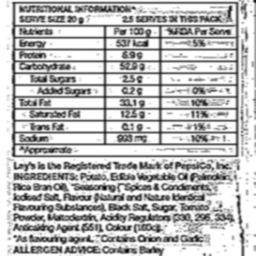

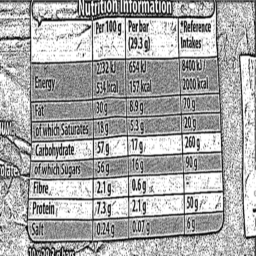

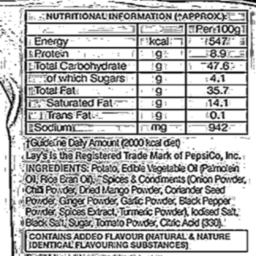

In [3]:
# Open the image file
image1 = preprocess_image(image_path="images/lays_cropped.jpg", show=True)

image2 = preprocess_image(image_path="images/cadbury.jpg", show=True)

image3 = preprocess_image(image_path="images/lays_magic_cropped.jpg", show=True)

In [4]:
# Open the file in read mode
# with open("src/prompts/label_prompt.txt", "r") as f:
#     # Read the contents of the file
#     file_contents = f.read()


# print(file_contents)

# label_extraction_prompt = file_contents

## Zero Shot Food Label Info Extraction

In [5]:
# llm = ChatGoogleGenerativeAI(model="gemini-pro-vision")

# # example
# message = HumanMessage(
#     content=[
#         {
#             "type": "text", # Text part of the prompt
#             "text": label_extraction_prompt,
#         },
#         {"type": "image_url", "image_url": image2}, # image part of the prompt
#     ]
# )

# response = llm.invoke([message])

In [6]:
# generated_text = response.content
# print(generated_text)

## Few Shot Prompt 

In [7]:
llm = ChatGoogleGenerativeAI(model="gemini-pro-vision")

prompt1 = lays_classic_example

prompt2 = cadbury_dairy_milk_example

In [8]:
image_message1 = {
    "type": "image_url",
    "image_url": image1
}

image_message2 = {
    "type": "image_url",
    "image_url": image2
}

image_message3 = {
    "type": "image_url",
    "image_url": image3
}

message = HumanMessage(content=[image_message1, prompt1, image_message2, prompt2, image_message3])

In [9]:
type(message)

langchain_core.messages.human.HumanMessage

In [10]:
response = llm.invoke([message])
output = response.content
print(response.content)

 nutritional information per 100 g: 
    json object'{"Energy": "547 kCal",
        "Macronutrients": { 
            "Protein": "8.9 g",
            "Carbohydrates": { 
                "Total": "47.6 g",
                "Sugar": "Not Present",
                },
            "Dietary Fiber": "Not Present",
            "Total Fat": {
                "Total": "35.7 g",
                "Saturated Fat": "14.1 g",
                "Trans Fat": "0.1 g",
                },
            "Linoleic Acid": "Not Present",
            "Linolenic acid": "Not Present"
        },
        "Minerals": { 
            "Calcium": "Not Present",
            "Iron": "Not Present",
            "Magnesium": "Not Present",
            "Phosphorus": "Not Present",
            "Potassium": "Not Present",
            "Sodium": "942 mg",
            "Zinc": "Not Present",
            "Cooper": "Not Present",
            "Manganese": "Not Present",
            "Selenium": "Not Present"
        },
        "Vitamins": { 

In [11]:
import json 

def process_output(output):

    # Extract the content between the triple quotes in the output string and convert that into a json object
    extracted_text = output.split('object')[1]

    print(extracted_text)

    extracted_dict = json.loads(extracted_text)

    print(extracted_dict)

    return extracted_text


extracted_text = process_output(output)

print(type(extracted_text))


'{"Energy": "547 kCal",
        "Macronutrients": { 
            "Protein": "8.9 g",
            "Carbohydrates": { 
                "Total": "47.6 g",
                "Sugar": "Not Present",
                },
            "Dietary Fiber": "Not Present",
            "Total Fat": {
                "Total": "35.7 g",
                "Saturated Fat": "14.1 g",
                "Trans Fat": "0.1 g",
                },
            "Linoleic Acid": "Not Present",
            "Linolenic acid": "Not Present"
        },
        "Minerals": { 
            "Calcium": "Not Present",
            "Iron": "Not Present",
            "Magnesium": "Not Present",
            "Phosphorus": "Not Present",
            "Potassium": "Not Present",
            "Sodium": "942 mg",
            "Zinc": "Not Present",
            "Cooper": "Not Present",
            "Manganese": "Not Present",
            "Selenium": "Not Present"
        },
        "Vitamins": {                
            "Vitamin A": "Not Presen

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [14]:
#include json library
import json

#json string data
employee_string = '{"first_name": "Michael", "last_name": "Rodgers", "department": "Marketing"}'

#check data type with type() method
print(type(employee_string))

#convert string to  object
json_object = json.loads(employee_string)

<class 'str'>


In [ ]:
output = response.content

## RAG based Retrieval

In [26]:
#Load the models
llm        = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0)
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

### Process the pdf file

In [27]:
loader = PyPDFLoader("docs/nutritional_tables_info.pdf")
docs   = loader.load()

In [28]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

In [29]:
# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)
prompt = hub.pull("rlm/rag-prompt")

In [30]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [31]:
output = rag_chain.invoke("""What are the nutritional requirements for a FEMALE in the age group between 14-18?""")

print(output)

The nutritional requirements for a female in the age group between 14-18 are as follows: 1800 kcal, 46 g of protein, 130 g of carbohydrates, 25.2 g of fiber, 1300 mg of calcium, 15 mg of iron, and 360 mg of magnesium.


In [3]:
import json
import re

# Given string
string = """nutritional information per 100 g: 
    json object'{"Energy": "537 kCal",
        "Macronutrients": { 
            "Protein": "6.9 g",
            "Carbohydrates": { 
                "Total": "52.9 g",
                "Sugar": "2.5 g"
                },
            "Dietary Fiber": "Not Present",
            "Total Fat": {
                "Total": "33.1 g",
                "Saturated Fat": "12.5 g",
                "Trans Fat": "0.1 g"
                },
            "Linoleic Acid": "Not Present",
            "Linolenic acid": "Not Present"
        },
        "Minerals": { 
            "Calcium": "Not Present",
            "Iron": "Not Present",
            "Magnesium": "Not Present",
            "Phosphorus": "Not Present",
            "Potassium": "Not Present",
            "Sodium": "993 mg",
            "Zinc": "Not Present",
            "Cooper": "Not Present",
            "Manganese": "Not Present",
            "Selenium": "Not Present"
        },
        "Vitamins": {                
            "Vitamin A": "Not Present",
            "Vitamic E": "Not Present",
            "Vitamin D": "Not Present",
            "Vitamin C": "Not Present",
            "Thiamin": "Not Present",
            "Riboflavin": "Not Present",
            "Niacin": "Not Present",
            "Vitamin B6": "Not Present",
            "Vitamin B12": "Not Present",
            "Choline": "Not Present",
            "Vitamin K": "Not Present",
            "Folate": "Not Present"             
    }
}"""

# Use regular expression to find JSON object
json_string = re.search(r'{.*}', string, re.DOTALL).group()

# Convert JSON string to dictionary
data = json.loads(json_string)

# Print the dictionary
print(data)


{'Energy': '537 kCal', 'Macronutrients': {'Protein': '6.9 g', 'Carbohydrates': {'Total': '52.9 g', 'Sugar': '2.5 g'}, 'Dietary Fiber': 'Not Present', 'Total Fat': {'Total': '33.1 g', 'Saturated Fat': '12.5 g', 'Trans Fat': '0.1 g'}, 'Linoleic Acid': 'Not Present', 'Linolenic acid': 'Not Present'}, 'Minerals': {'Calcium': 'Not Present', 'Iron': 'Not Present', 'Magnesium': 'Not Present', 'Phosphorus': 'Not Present', 'Potassium': 'Not Present', 'Sodium': '993 mg', 'Zinc': 'Not Present', 'Cooper': 'Not Present', 'Manganese': 'Not Present', 'Selenium': 'Not Present'}, 'Vitamins': {'Vitamin A': 'Not Present', 'Vitamic E': 'Not Present', 'Vitamin D': 'Not Present', 'Vitamin C': 'Not Present', 'Thiamin': 'Not Present', 'Riboflavin': 'Not Present', 'Niacin': 'Not Present', 'Vitamin B6': 'Not Present', 'Vitamin B12': 'Not Present', 'Choline': 'Not Present', 'Vitamin K': 'Not Present', 'Folate': 'Not Present'}}
